# Libraries

In [1]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Dataset

In [2]:
query = "Query_AI-magazines-mediacloud-2021-24"

FEATHER_FILE = query + ".feather"
df = pd.read_feather('data/' + FEATHER_FILE)


# Drop rows where the 'Name' column has an empty string
df = df[df['text'] != '']

df = df.drop('text_downloaded', axis=1)
df = df.drop('indexed_date', axis=1)
df = df.drop('language', axis=1)
df = df.drop('media_url', axis=1)
df = df.drop('id', axis=1)


df = df.reset_index(drop=True)

# df.sample(1)
df.iloc[[1]]
# df['A'] = df['A'].apply(lambda x: list(set(x)))

,media_name,publish_date,title,url,year,text,GPE,IND,ORG
1,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"[Midjourney, LA, Netherlands]","[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ..."


## Cleaning

In [3]:
df['GPE'] = df['GPE'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
df['IND'] = df['IND'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
df['ORG'] = df['ORG'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)

df.iloc[[1]]

,media_name,publish_date,title,url,year,text,GPE,IND,ORG
1,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"[Midjourney, LA, Netherlands]","[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ..."


In [57]:
#IND

# Lista de nombres completos que queremos reemplazar
names_to_replace = {
    'Hanna': 'Hanna Rosin',
    'Rosin':'Hanna Rosin',
    'Mike ':'Mike Calore',
    'Calore':'Mike Calore',
    'Li': 'Li Yizhou',
    'Yizhou': 'Li Yizhou',
    'Sam': 'Sam Altman',
    'Altman': 'Sam Altman',
    'Marc ': 'Marc Andreessen',
    'Andreessen': 'Marc Andreessen',
    'Timnit': 'Timnit Gebru',
    'Gebru': 'Timnit Gebru',
    'Lauren': 'Lauren Goode',
    'Goode': 'Lauren Goode',
    'Michael': 'Michael Calore',
    'Calore': 'Michael Calore',
    'Elon': 'Elon Musk',
    'Musk': 'Elon Musk',
    'Donald': 'Donald Trump',
    'Trump': 'Donald Trump',
    'Joe': 'Joe Biden',
    'Biden': 'Joe Biden',
    'Laurel': 'Laurel Ruma',
    'Ruma': 'Laurel Ruma',
    'Sam': 'Sam Altman',
    'Altman': 'Sam Altman',
    'Geoffrey': 'Geoffrey Hinton',
    'Hinton': 'Geoffrey Hinton',
    'Jennifer': 'Jennifer Strong',
    'Strong': 'Jennifer Strong',
    'Gideon': 'Gideon Lichfield',
    'Lichfield': 'Gideon Lichfield',
    'Will': 'Will Knight',
    'Knight': 'Will Knight',
    'Kamala': 'Kamala Harris',
    'Harris': 'Kamala Harris',
    'Mark': 'Mark Zuckerberg',
    'Zuckerberg': 'Mark Zuckerberg',
    'Boone': 'Boone Ashworth',
    'Ashworth': 'Boone Ashworth',
    'Xi': 'Xi Jinping',
    'Jinping': 'Xi Jinping',
    'Bill': 'Bill Gates',
    'Gates': 'Bill Gates',
    'Paresh': 'Paresh Dave',
    'Dave': 'Paresh Dave',
    'Ernie': 'Ernie Bot',
    'Bot': 'Ernie Bot',
    'Mustafa': 'Mustafa Suleyman',
    'Suleyman': 'Mustafa Suleyman',
    'Taylor': 'Taylor Swift',
    'Swift': 'Taylor Swift'
}

# Función para reemplazar los nombres en la lista
def replace_names(name_list):
    # Reemplazamos los nombres según el diccionario
    return [names_to_replace.get(name, name) for name in name_list]

# Aplicamos la función a la columna 'IND'
df['IND'] = df['IND'].apply(replace_names)

In [59]:
#GPE

# Lista de nombres completos que queremos reemplazar
names_to_replace = {
    'US': 'The United States',
    'U.S.':'The United States',
    'the United States  ':'The United States',
    
}

# Función para reemplazar los nombres en la lista
def replace_names(name_list):
    # Reemplazamos los nombres según el diccionario
    return [names_to_replace.get(name, name) for name in name_list]

# Aplicamos la función a la columna 'IND'
df['GPE'] = df['GPE'].apply(replace_names)

In [60]:
df.head(50)

,media_name,publish_date,title,url,year,text,GPE,IND,ORG
0,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,[Midjourney],"[Shawn Shan, Shawn Shan, Shawn Shan, Shawn Sha...","[Glaze, Nightshade, MIT Technology Review, the..."
1,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"[Midjourney, LA, Netherlands]","[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ..."
2,wired.com,2024-09-10,Why Is AI So Bad at Generating Images of Kamal...,https://www.wired.com/story/bad-kamala-harris-...,2024,When Elon Musk shared an image showing Kamala ...,"[Midjourney, Freepik]","[Elon Musk, Kamala Harris, Kamala Harris, Kama...","[X, Grok, Grok, AMERICAN, Grok, Grok, the Cent..."
3,wired.com,2024-09-10,Which iPhone 16 Model Should You Buy?,https://www.wired.com/story/which-apple-iphone...,2024,If you buy something using links in our storie...,"[|128, |128, |$999]","[Pro Max, Pro Max, Pro Max, Pro Max, Pro Max, ...","[Apple, Apple, Apple Intelligence, Apple, Appl..."
4,wired.com,2024-09-10,Crispr-Enhanced Viruses Are Being Deployed Aga...,https://www.wired.com/story/crispr-enhanced-vi...,2024,The global rise in antibiotic resistance is ma...,"[North Carolina, Soviet Union, the Republic of...","[Crispr, Crispr, Crispr, Crispr, Paul Garofolo...","[Locus Biosciences, Locus, Locus, UTI, The Lan..."
5,wired.com,2024-09-10,Inside Google’s 7-Year Mission to Give AI a Ro...,https://www.wired.com/story/inside-google-miss...,2024,"It was early January 2016, and I had just join...","[Oslo, Norway, NYC, Netherlands, Japan, China,...","[Andy, Rubin, Larry Page, Sergey Brin, Astro T...","[Google X, Alphabet, Google, Google X, Astro, ..."
6,wired.com,2024-09-09,This iPhone ‘Supercycle’ May Not Be So Super,https://www.wired.com/story/iphone-16-supercycle/,2024,Apple’s just-announced iPhone 16 and iPhone 16...,"[UK, The United States, China, China, China, C...","[Dan Ives, Erik Woodring, Maya Nueman, Ives, P...","[Apple, iPhone, Apple, Apple, Wedbush Securiti..."
7,wired.com,2024-09-09,Google Pixel Watch 3 Is Finally the Apple Watc...,https://www.wired.com/review/google-pixel-watc...,2024,It is a little crazy to think about where Goog...,[The United States],"[Adrienne, James Bond]","[Google, Samsung, Apple, the Pixel Watch 3, Go..."
8,wired.com,2024-09-09,James Earl Jones' Darth Vader Has Already Been...,https://www.wired.com/story/james-earl-jones-d...,2024,"If anyone could make the Dark Side sound good,...","[Russia, Ukraine, Hollywood]","[James Earl Jones, Darth Vader, Jones, Jones, ...","[Star Tours, Force, AI, Vanity Fair, Lucasfilm..."
9,wired.com,2024-09-09,"Everything Apple Announced Today: iPhone 16, A...",https://www.wired.com/story/everything-apple-a...,2024,If you buy something using links in our storie...,[],"[Glowtime, Pro Max, Julian Chokkattu, Adrienne...","[Apple, Apple Watch, Apple Intelligence, Apple..."


In [61]:
df.iloc[[1]]

,media_name,publish_date,title,url,year,text,GPE,IND,ORG
1,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"[Midjourney, LA, Netherlands]","[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ..."


## Years

In [62]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer
df = df.reset_index(drop=True)

print(set(df["year"].tolist()))

{2024, 2021, 2022, 2023}


## Entities

In [63]:
entities = np.empty((0, 12), dtype=object)

years_template = {}

for year in sorted(set(df["year"].tolist())):
    years_template[year] = 0


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in df.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]

    gpe = row["GPE"]
    ind = row["IND"]
    org = row["ORG"]
    # tag = row["TAG"]
    
    cooccurrences = list(gpe) + list(ind) + list(org)
    # cooccurrences = list(gpe + ind + org + tag)

    for entity in gpe:
        update(entity, "gpe")
    
    for entity in ind:
        update(entity, "ind")

    for entity in org:
        update(entity, "org")

    # for entity in tag:
    #     update(entity, "tag")


# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)

The total number of entities is 23905


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
15,AI,org,5411,NaN,None,-1,-1,-1,"{2021: 810, 2022: 375, 2023: 2466, 2024: 1760}",[https://www.technologyreview.com/2024/09/10/1...,[2024 Innovator of the Year: Shawn Shan builds...,"[Midjourney, Shawn Shan, Shawn Shan, Shawn Sha..."


# Treatment

## Normalization

In [64]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
15438,Robert Caro,ind,1,NaN,None,-1,-1,-1,"{2021: 0, 2022: 0, 2023: 1, 2024: 0}",[https://www.wired.com/story/plaintext-everyon...,[Everyone Wants to Regulate AI. No One Can Agr...,"[The United States, The United States, India, ...",0.0,"{""2021"": 0, ""2022"": 0, ""2023"": 1, ""2024"": 0}"


## Filter Entities

In [65]:

# counting

len_gpe = entities_all.loc[(entities_all["type"] == "gpe")].shape[0]
len_ind = entities_all.loc[(entities_all["type"] == "ind")].shape[0]
len_org = entities_all.loc[(entities_all["type"] == "org")].shape[0]
# len_tag = entities_all.loc[(entities_all["type"] == "tag")].shape[0]

print(len_gpe, len_ind, len_org)


# max_gpe = 0
# max_ind = 100
# max_org = 0
# max_tag = 100

min_frequency = 30



top_gpe = (
    entities_all.loc[
        (entities_all["type"] == "gpe")
        & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    # .head(max_gpe)
)
top_ind = (
    entities_all.loc[
        (entities_all["type"] == "ind")
        & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    # .head(max_ind)
)
top_org = (
    entities_all.loc[
        (entities_all["type"] == "org")
        & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    # .head(max_org)
)
# top_tag = (
#     entities_all.loc[
#         (entities_all["type"] == "tag")
#         & (entities_all["frequency"] > min_frequency * .5)
#     ]
#     .sort_values(by=["frequency"], ascending=False)
#     # .head(max_tag)
# )

entities = pd.concat([top_gpe, top_ind, top_org])

len(entities) # 400 is a good number for the map

1513 11177 11215


381

In [66]:
entities.sample(3)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
1138,Eileen Guo,ind,31,NaN,None,-1,-1,-1,"{2021: 0, 2022: 2, 2023: 26, 2024: 3}",[https://www.technologyreview.com/2024/08/20/1...,[Why you’re about to see a lot more drones in ...,"[Texas, The United States, The United States, ...",0.005545,"{""2021"": 0, ""2022"": 2, ""2023"": 26, ""2024"": 3}"
2479,NLP,org,87,NaN,None,-1,-1,-1,"{2021: 82, 2022: 0, 2023: 4, 2024: 1}",[https://www.theverge.com/24201441/ai-terminol...,"[AI terminology, explained for humans, This co...","[Georgetown, Seattle, OpenAI, Mark Zuckerberg,...",0.015896,"{""2021"": 82, ""2022"": 0, ""2023"": 4, ""2024"": 1}"
3731,Copilot,org,64,NaN,None,-1,-1,-1,"{2021: 7, 2022: 11, 2023: 30, 2024: 16}",[https://www.theverge.com/2024/6/25/24185462/m...,[Surface Laptop review: Microsoft’s best MacBo...,"[UK, 3DMark, jack, Blake Manfre, Microsoft, Qu...",0.011645,"{""2021"": 7, ""2022"": 11, ""2023"": 30, ""2024"": 16}"


## Linear Regression

In [67]:
# For each entity

for i, row in entities.iterrows():

    x = list(row["years"].keys()) # Extract years
    x = [int(numeric_string) for numeric_string in x] # Set to int
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row["years"].values()) # Extract frequency
    y = np.array(y) # To Numpy (code works without this line)

    regression = LinearRegression()
    regression.fit(x, y)
    
    entities.at[i, "slope"] = regression.coef_[0] # compute linear regression


# normalization by type

scale = 1

for type in entities["type"].unique():

    selection = entities.loc[entities["type"] == type]
    mean = selection["slope"].mean() * scale
    
    for i, row in selection.iterrows():
        entities.at[i, "slope"] = row["slope"] - mean


entities.sample()


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
4454,David Brown,ind,53,-6.771681,None,-1,-1,-1,"{2021: 0, 2022: 0, 2023: 52, 2024: 1}",[https://www.theverge.com/c/24133822/microsoft...,"[The Excel superstars throw down in Vegas, Art...","[Vegas, Las Vegas, Vegas, Vegas, New York, Lon...",0.009612,"{""2021"": 0, ""2022"": 0, ""2023"": 52, ""2024"": 1}"


## Colors

In [68]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] == "tag":
        entities.at[i, "color"] = "#cccccc"
    else:
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
114,The United States,gpe,2462,198.352113,#b40426,-1,-1,-1,"{2021: 340, 2022: 340, 2023: 928, 2024: 854}",[https://www.wired.com/story/crispr-enhanced-v...,[Crispr-Enhanced Viruses Are Being Deployed Ag...,"[North Carolina, Soviet Union, the Republic of...",0.454898,"{""2021"": 340, ""2022"": 340, ""2023"": 928, ""2024""..."


# Embedding

## Term Frequency

In [69]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


c:\Users\UserAlba\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## UMAP

c:\Users\UserAlba\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


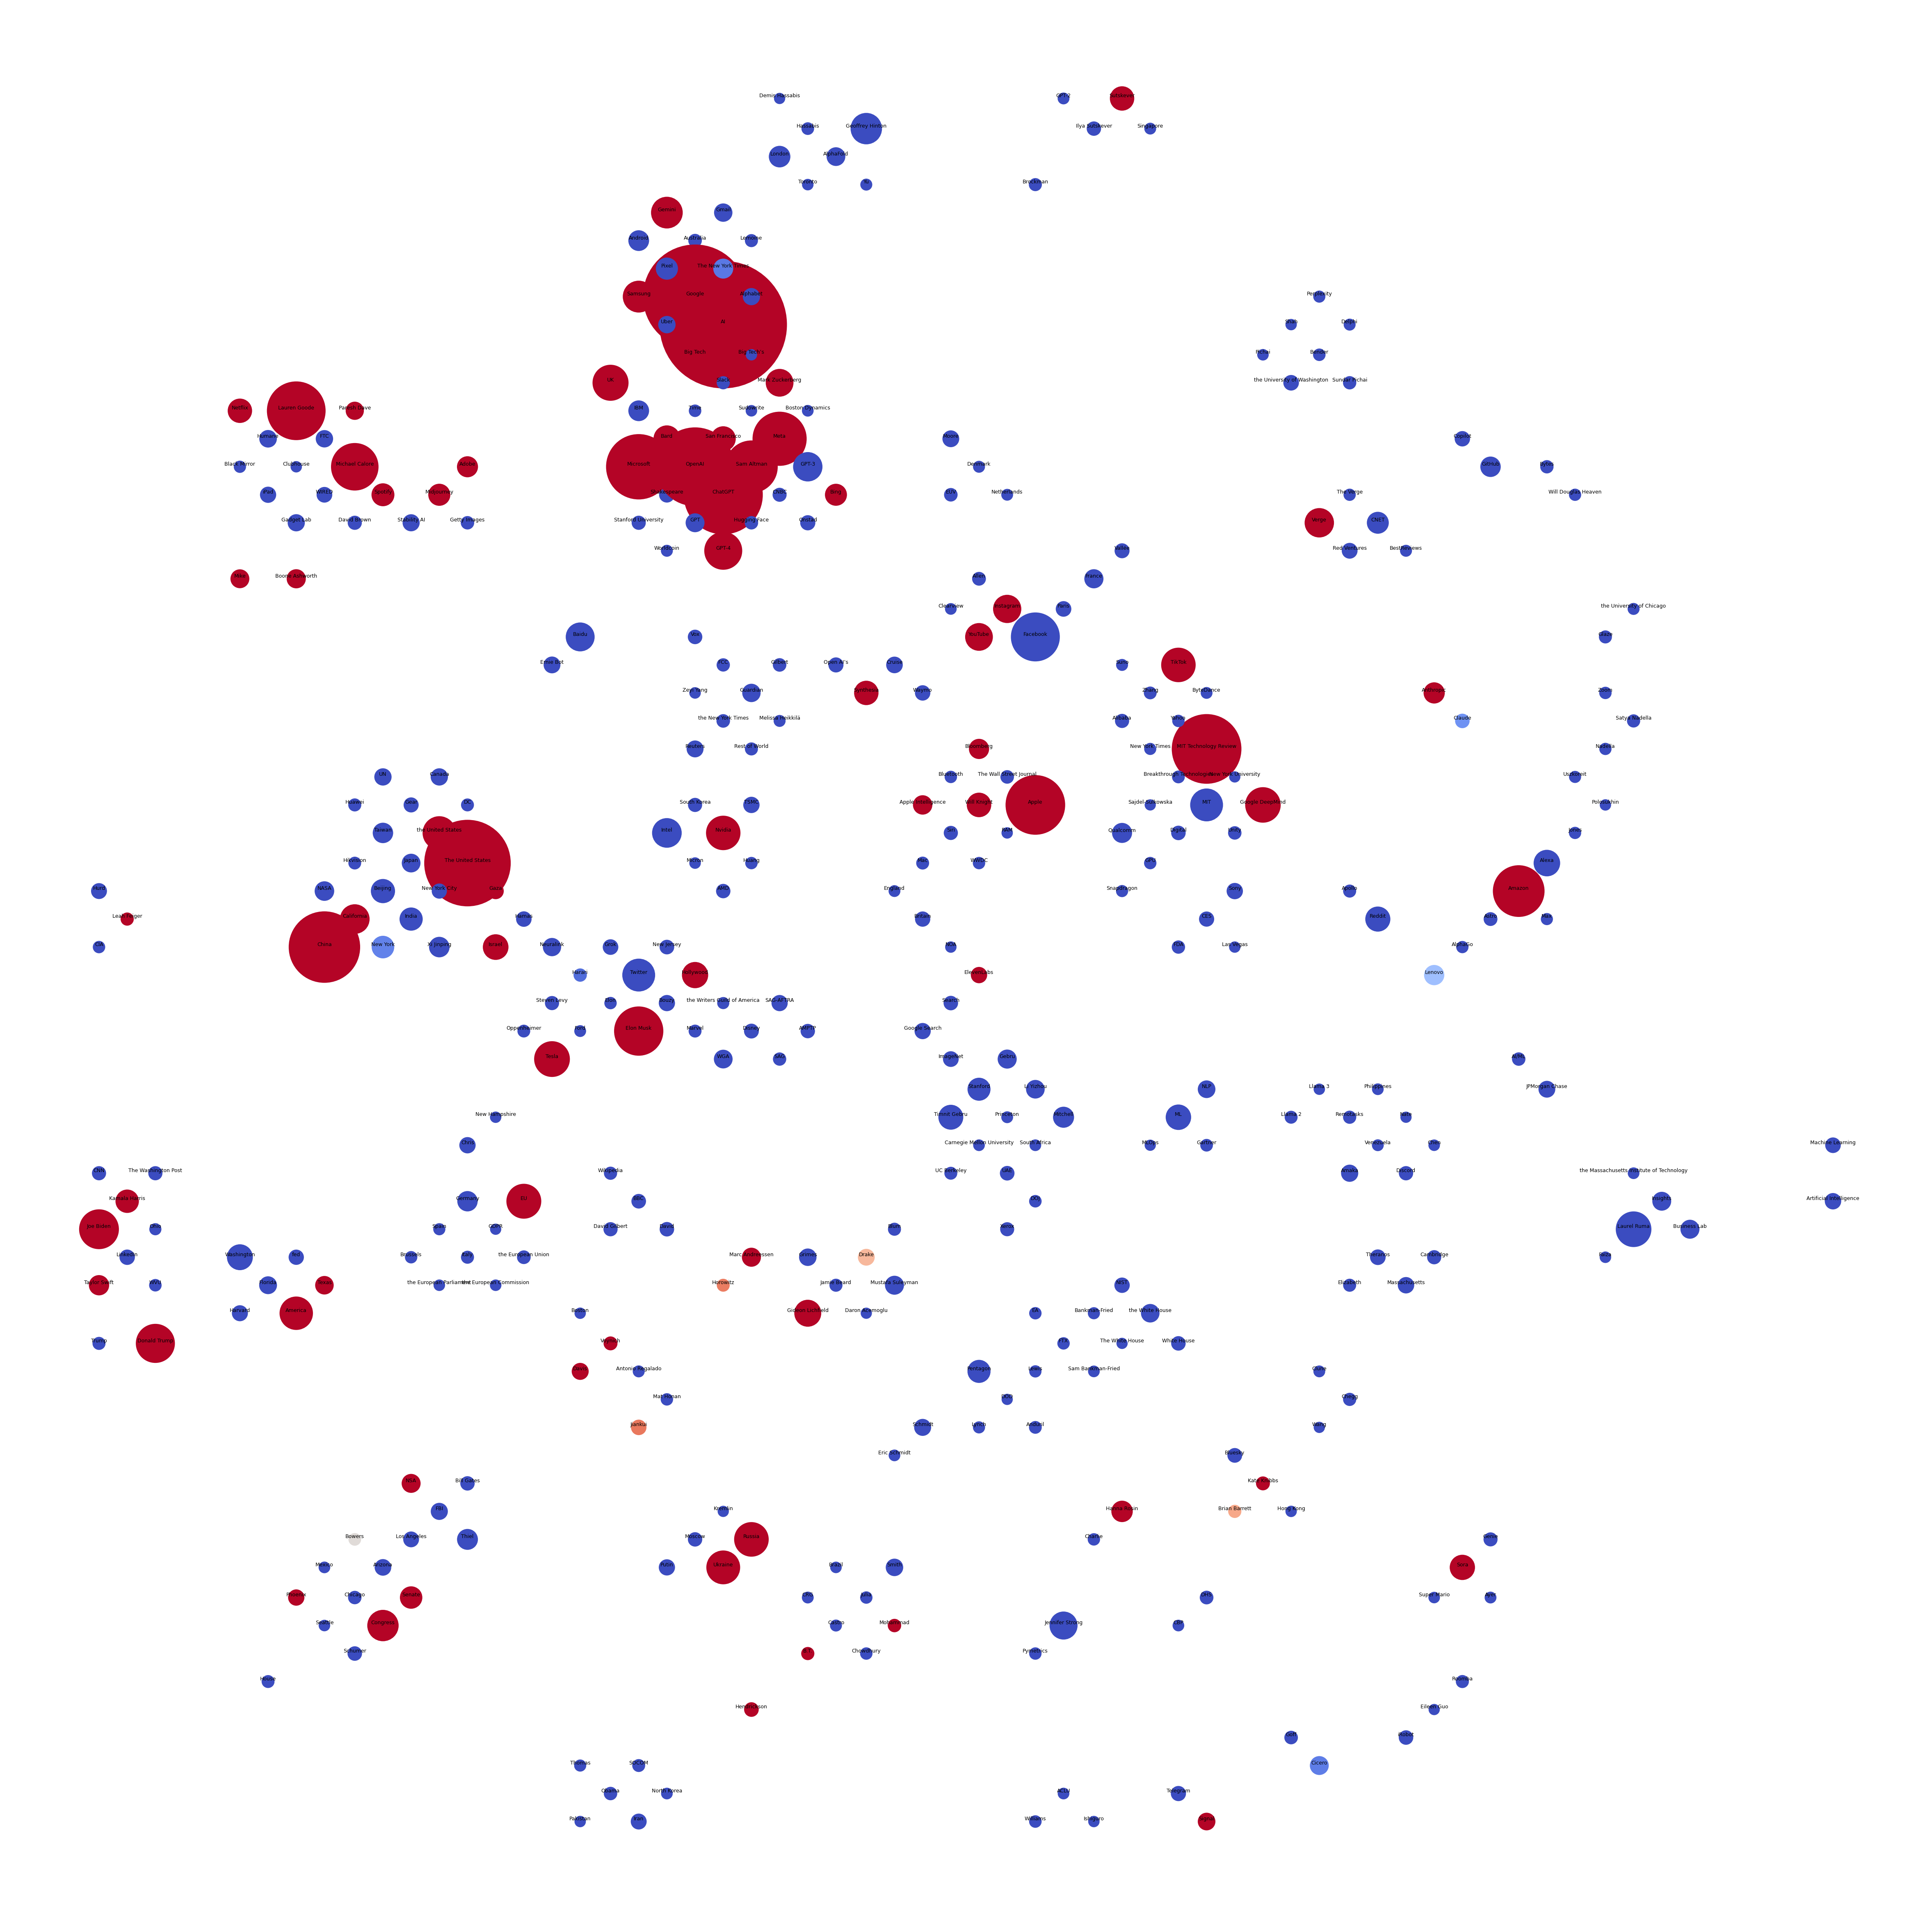

In [70]:
reducer = umap.UMAP(
    random_state=5,
    n_components=2,
    n_neighbors=2,
    min_dist=0.1,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


PLAY WITH

c:\Users\UserAlba\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


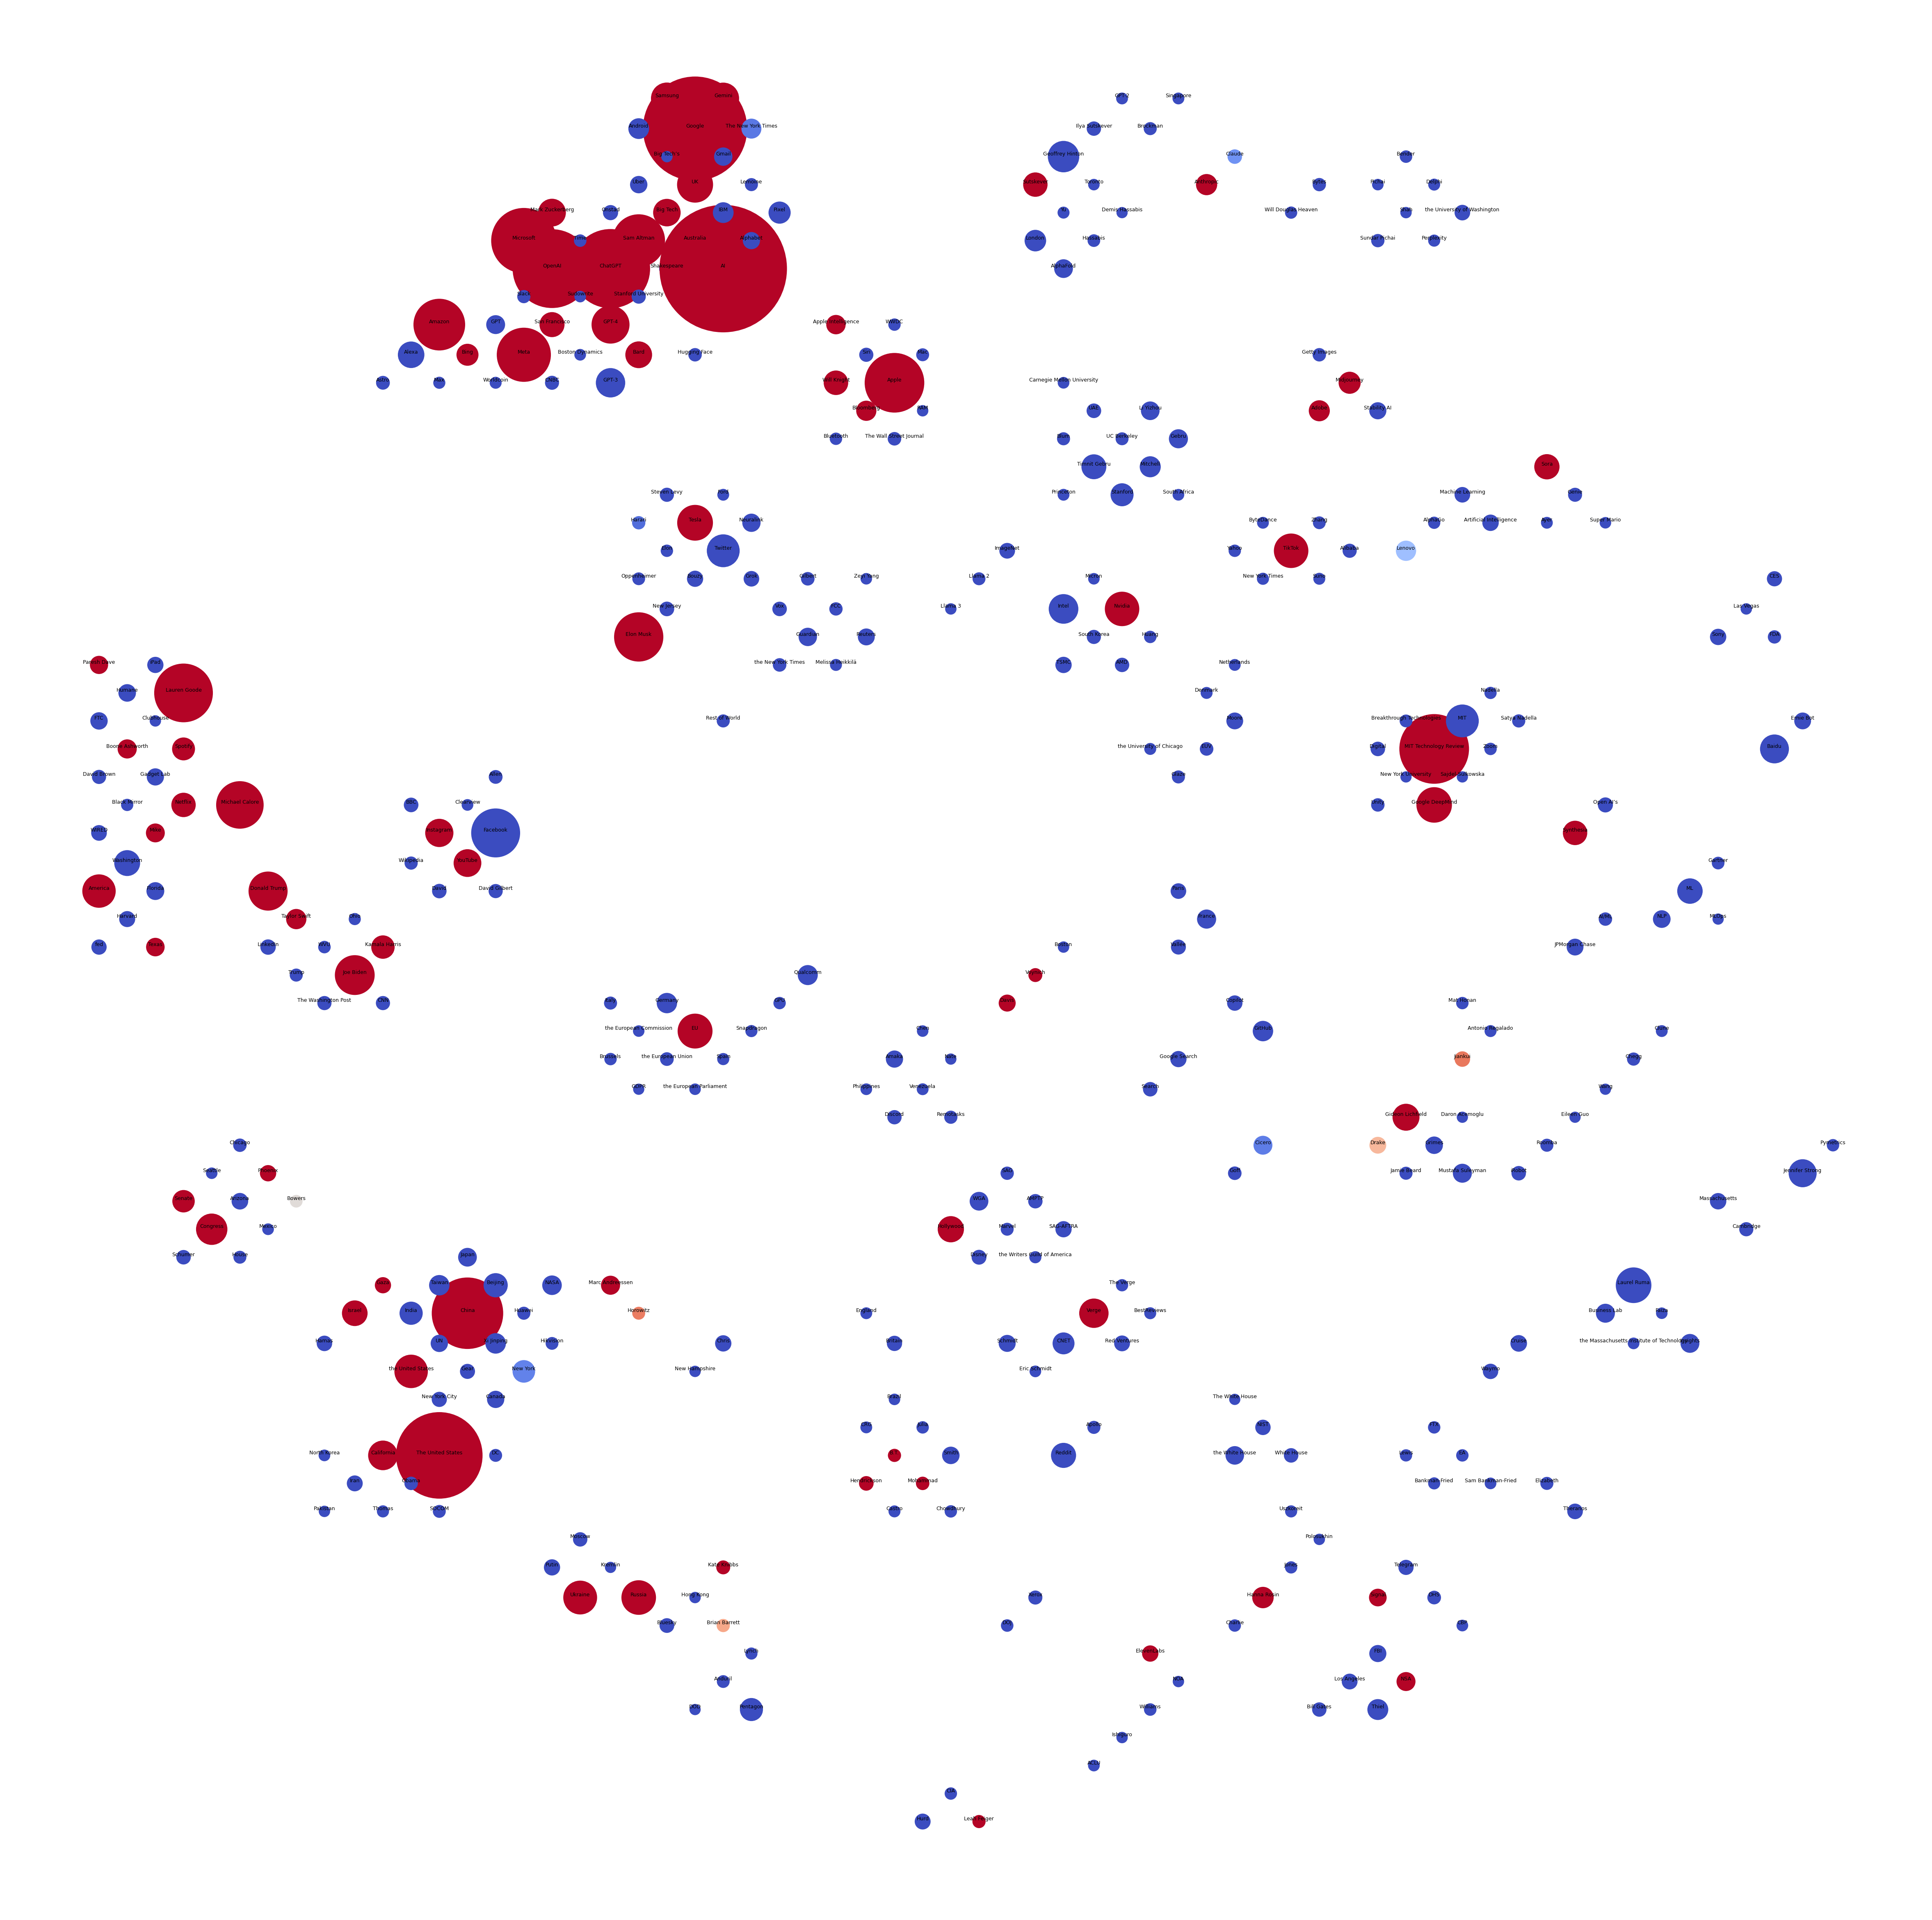

In [71]:
reducer = umap.UMAP(
    random_state=5,
    n_components=2,
    n_neighbors=2,
    min_dist=0.1,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")

## Clustering

In [72]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=3,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=5, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    entities.loc[(entities["type"] != "tag") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "tag") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
28,Clearview,org,34,-20.795939,#3b4cc0,270,572,n_3,"{2021: 20, 2022: 0, 2023: 10, 2024: 4}",[https://www.technologyreview.com/2024/09/10/1...,[What impact will AI have on video game develo...,"[Midjourney, LA, Netherlands, Roblox, Roblox, ...",0.0061,"{""2021"": 20, ""2022"": 0, ""2023"": 10, ""2024"": 4}"


{'n_6', 'n_19', 'n_3', 'p_5', 'p_0', 'n_18', 'n_1', 'p_1', 'n_8', 'n_14', 'n_17', 'p_2', 'n_9', 'n_22', 'n_25', 'n_28', 'n_20', 'p_4', 'n_13', 'n_27', 'n_7', 'n_15', '-1', 'n_21', 'n_11', 'n_24', 'n_5', 'n_2', 'n_26', 'n_23', 'p_3', 'n_0', 'n_16', 'n_29', 'n_10', 'n_4', 'n_30', 'n_12'}
6
7
13
10
4
7
8
6
10
6
4
24
25
6
18
4
7
5
3


QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 570625102  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 26  Error-roundoff 4.8e-13  _one-merge 2.4e-12
  _near-inside 1.2e-11  Visible-distance 9.5e-13  U-max-coplanar 9.5e-13
  Width-outside 1.9e-12  _wide-facet 5.7e-12  _maxoutside 2.9e-12

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p0(v3): 5.8e+02 1.5e+02
- p2(v2): 6e+02 1.6e+02
- p1(v1): 5.7e+02 1.4e+02

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 4.8e-13.  The center point, facets and distances
to the center point are as follows:

center point      585      152

facet p2 p1 distance= -7.1e-14
facet p0 p1 distance= 1.4e-14
facet p0 p2 distance= 1.4e-14

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:       572       598  difference=   26
  1:       139       165  difference=   26

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 4.8e-13.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


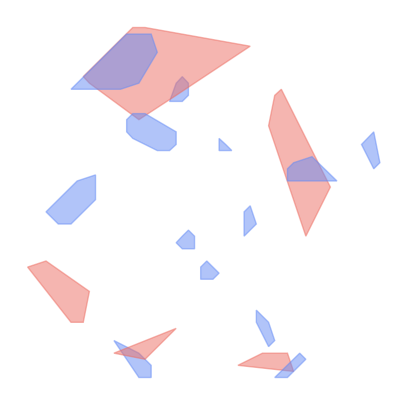

In [73]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [75]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
230,Disney,org,59,-8.095939,#3b4cc0,506,362,n_19,[https://www.wired.com/story/james-earl-jones-...,0.010721,"{""2021"": 1, ""2022"": 1, ""2023"": 39, ""2024"": 18}"
